In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

os.chdir("/wynton/group/capra/projects/modern_human_3Dgenome")

BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level

BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data.
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
#COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")

In [2]:
BASE_PATH

'/wynton/group/capra/projects/modern_human_3Dgenome'

In [3]:
# Function for custom colormaps, from
# https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

import matplotlib.colors as mcolors

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def one_comparison_parse(ind1, ind2, matrix_seq, dict_seq, windows ):
    df = pd.read_csv(f"{seqComps_dir}/SeqComps_{ind1}_vs_{ind2}.txt", sep="\t", index_col=[0,1])
    df = df.loc[windows.index]
    avg = 1-df['seqComp_raw'].astype('float').mean()
    matrix_seq.loc[ind1,ind2] = avg
    matrix_seq.loc[ind2,ind1] = avg
    for w in windows.index:
        window_seq_diff = 1-float(df.loc[w]['seqComp_raw'])
        dict_seq[w].loc[ind1,ind2] = window_seq_diff
        dict_seq[w].loc[ind2,ind1] = window_seq_diff

    return matrix_seq, dict_seq

def one_comparison_parse_3d(ind1, ind2, matrix_3d, dict_3d, windows ):
    df = pd.read_csv(f"{Comps3d_dir}/3dcomp_{ind1}_vs_{ind2}.txt", sep="\t", index_col=[0,1])
    df = df.loc[windows.index]
    avg = (1-df['spearman'].astype('float')).mean()
    matrix_3d.loc[ind1,ind2] = avg
    matrix_3d.loc[ind2,ind1] = avg
    for w in windows.index:
        window_3d_diff = 1-float(df.loc[w]['spearman'])
        dict_3d[w].loc[ind1,ind2] = window_3d_diff
        dict_3d[w].loc[ind2,ind1] = window_3d_diff

    return matrix_3d, dict_3d

In [4]:
# Create pickle data structures for sequence and 3D by window
# Comps3d_dir = "/wynton/group/capra/projects/modern_human_3Dgenome/data/pairwise/subsample"
# count = 0
# dict_3d = {k: pd.DataFrame(index=all_indivs, columns=all_indivs,dtype='float') for k in windows.index} # takes about  50 sec
# matrix_3d = pd.DataFrame(index=all_indivs, columns=all_indivs,dtype='float')
# for i in comp_list.index: # 3 minutes per 50 iterations, 503 minutes total, 8 hours
#     ind1 = comp_list.loc[i]['ind1']
#     ind2 = comp_list.loc[i]['ind2']
#     matrix_3d, dict_3d = one_comparison_parse_3d(ind1, ind2, matrix_3d, dict_3d, windows)
#     count +=1 
#     if count%50 == 0:
#         print(count)

# pickle.dump( dict_3d, open( "dict_3d.p", "wb" ) )
# pickle.dump( matrix_3d, open( "matrix_3d.p", "wb" ) )

# seqComps_dir = "/wynton/group/capra/projects/modern_human_3Dgenome/data/pairwise/sequence/1KGvs1KG"
# count = 0
# dict_seq = {k: pd.DataFrame(index=all_indivs, columns=all_indivs,dtype='float') for k in windows.index} # takes about  50 sec
# matrix_seq = pd.DataFrame(index=all_indivs, columns=all_indivs,dtype='float')
# for i in comp_list.index: # 3 minutes per 50 iterations, 503 minutes total, 8 hours
#     ind1 = comp_list.loc[i]['ind1']
#     ind2 = comp_list.loc[i]['ind2']
#     matrix_seq, dict_seq = one_comparison_parse(ind1, ind2, matrix_seq, dict_seq, windows)
#     count +=1 
#     if count%50 == 0:
#         print(count)

# pickle.dump( dict_seq, open( "dict_seq.p", "wb" ) )
# pickle.dump( matrix_seq, open( "matrix_seq.p", "wb" ) )

In [5]:
comp_list = pd.read_csv('/wynton/group/capra/projects/modern_human_3Dgenome/results/comp_tables/pairwise_subsample_genomewide_averages.csv',
                       index_col=0)
all_indivs = list(set(comp_list.ind1.unique()) | set(comp_list.ind2.unique()))
windows = pd.read_table('%s/intermediates/windows_to_keep.csv' % DATA_PATH, sep=',', index_col=[1,2]).drop(columns=['Unnamed: 0'])

dict_seq = pickle.load( open( "dict_seq.p", "rb" ) )
matrix_seq = pickle.load( open( "matrix_seq.p", "rb" ) )

dict_3d = pickle.load( open( "dict_3d.p", "rb" ) )
matrix_3d = pickle.load( open( "matrix_3d.p", "rb" ) )


In [77]:

def one_window_tree(dict3d, w, tree_summary, tree_complete, link_method):
        window_df = dict_3d[w]
        idx = sorted(set(window_df.index).union(window_df.columns))
        length = len(idx)
        array = window_df.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
        condensed = array[np.triu_indices(length, k = 1)]
        Z = sch.linkage(condensed, method = link_method)
        dendrogram = sch.dendrogram(Z)
        whole_tree = [Z, dendrogram]

        cluster_sample_IDs = dendrogram['leaves']
        cluster_IDs = dendrogram['leaves_color_list']
        clusters_dict = dict(zip(cluster_sample_IDs, cluster_IDs))

        cluster_IDs_list = []
        for key, value in sorted(clusters_dict.items()):
                cluster_IDs_list.append(value)

        top_tree_y = dendrogram['dcoord'][-1]
        window_stats = cluster_IDs_list + top_tree_y


        return window_stats, whole_tree

In [63]:
windows_tuples = list(dict_3d.keys())

In [64]:
windows_tuples

[('chr1', 1048576),
 ('chr1', 1572864),
 ('chr1', 3145728),
 ('chr1', 3670016),
 ('chr1', 4194304),
 ('chr1', 4718592),
 ('chr1', 5242880),
 ('chr1', 5767168),
 ('chr1', 6291456),
 ('chr1', 6815744),
 ('chr1', 7340032),
 ('chr1', 7864320),
 ('chr1', 8388608),
 ('chr1', 8912896),
 ('chr1', 9437184),
 ('chr1', 9961472),
 ('chr1', 10485760),
 ('chr1', 11010048),
 ('chr1', 11534336),
 ('chr1', 13107200),
 ('chr1', 13631488),
 ('chr1', 14155776),
 ('chr1', 14680064),
 ('chr1', 15204352),
 ('chr1', 15728640),
 ('chr1', 17301504),
 ('chr1', 17825792),
 ('chr1', 18350080),
 ('chr1', 18874368),
 ('chr1', 19398656),
 ('chr1', 19922944),
 ('chr1', 20447232),
 ('chr1', 20971520),
 ('chr1', 21495808),
 ('chr1', 22020096),
 ('chr1', 22544384),
 ('chr1', 23068672),
 ('chr1', 23592960),
 ('chr1', 24117248),
 ('chr1', 24641536),
 ('chr1', 25165824),
 ('chr1', 25690112),
 ('chr1', 26214400),
 ('chr1', 26738688),
 ('chr1', 27262976),
 ('chr1', 27787264),
 ('chr1', 28311552),
 ('chr1', 29884416),
 ('chr1'

0
100
200


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


300
400
500
600
700
800
900
1000


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


1100
1200
1300
1400
1500
1600


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


2900
3000
3100
3200
3300
3400


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


3500
3600
3700
3800
3900
4000
4100
4200
4300


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


4400


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


4500


/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/wynton/home/capra/egilbertson/.conda/envs/modern3d/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:2845: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])


4600
4700
4800


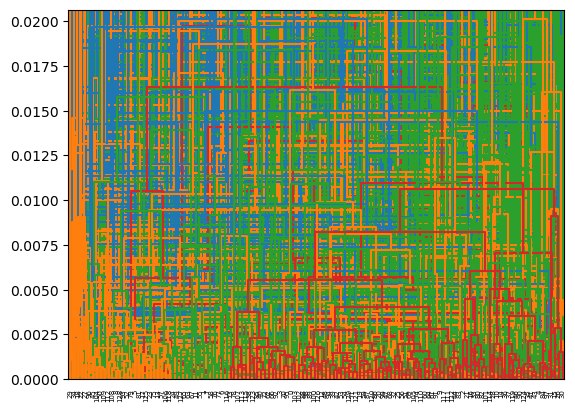

In [78]:
tree_summary = {}
tree_complete = {}

#takes about 3 minutes 2 seconds +/-
for i in range(len(windows_tuples)):
    w = windows_tuples[i]
    window_stats, whole_tree = one_window_tree(dict_3d, w, tree_summary, tree_complete, link_method='complete')
    tree_summary[w] = window_stats
    tree_complete[w] = whole_tree

    if i%100==0:
        print(i)

In [79]:
dataframe = pd.DataFrame.from_dict(tree_summary, orient='index', columns=[idx + ['coord_0','coord_1','coord_2','coord_3']])


In [81]:
dataframe

,AFR_ACB_female_HG01896,AFR_ACB_female_HG02095,AFR_ACB_female_HG02337,AFR_ACB_female_HG02505,AFR_ACB_female_HG02555,AFR_ASW_female_NA19625,AFR_ASW_female_NA19901,AFR_ASW_female_NA19917,AFR_ASW_female_NA20314,AFR_ASW_female_NA20317,...,SAS_PJL_female_HG03619,SAS_STU_female_HG03673,SAS_STU_female_HG03836,SAS_STU_female_HG03886,SAS_STU_female_HG03944,SAS_STU_female_HG03949,coord_0,coord_1,coord_2,coord_3
"(chr1, 1048576)",C3,C2,C1,C3,C1,C3,C2,C3,C2,C1,...,C1,C1,C1,C1,C2,C1,0.003841,0.007679,0.007679,0.005397
"(chr1, 1572864)",C2,C1,C1,C1,C1,C2,C1,C2,C1,C1,...,C1,C1,C1,C1,C1,C1,0.005181,0.008876,0.008876,0.005194
"(chr1, 3145728)",C3,C3,C3,C2,C3,C3,C3,C3,C3,C3,...,C1,C1,C3,C3,C3,C1,0.009073,0.019304,0.019304,0.015601
"(chr1, 3670016)",C1,C2,C1,C2,C2,C2,C0,C1,C1,C2,...,C2,C2,C2,C2,C1,C2,0.009561,0.016704,0.016704,0.013077
"(chr1, 4194304)",C1,C2,C1,C2,C2,C2,C2,C1,C1,C2,...,C2,C2,C2,C2,C1,C2,0.008759,0.028704,0.028704,0.016627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(chr22, 46661632)",C3,C1,C3,C3,C3,C3,C3,C3,C3,C1,...,C3,C3,C3,C3,C3,C3,0.008802,0.029379,0.029379,0.026046
"(chr22, 47185920)",C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,...,C1,C0,C1,C1,C1,C1,0.000000,0.328717,0.328717,0.075794
"(chr22, 47710208)",C1,C1,C2,C2,C2,C1,C1,C1,C1,C1,...,C1,C1,C1,C1,C1,C1,0.074460,0.145304,0.145304,0.097766
"(chr22, 48234496)",C2,C2,C2,C2,C2,C2,C2,C2,C2,C2,...,C2,C2,C2,C2,C2,C2,0.059063,0.301997,0.301997,0.085105


In [80]:
tree_summary[('chr1', 1048576)]

['C3',
 'C2',
 'C1',
 'C3',
 'C1',
 'C3',
 'C2',
 'C3',
 'C2',
 'C1',
 'C1',
 'C3',
 'C1',
 'C1',
 'C1',
 'C3',
 'C3',
 'C3',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C3',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C2',
 'C3',
 'C3',
 'C1',
 'C3',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C2',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C2',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 0.0038408288963821535,
 0.007679464459487195,
 0.007679464459487195,
 0.00539661688473835

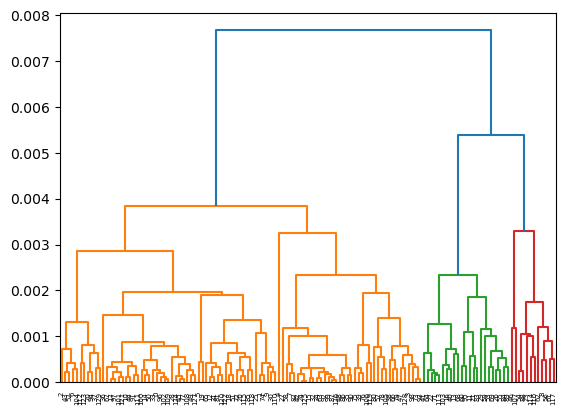

In [9]:

dendrogram = sch.dendrogram(sch.linkage(array, method = 'complete'))

In [10]:
cluster_sample_IDs = dendrogram['leaves']
cluster_IDs = dendrogram['leaves_color_list']
clusters_dict = dict(zip(cluster_sample_IDs, cluster_IDs))

cluster_IDs_list = []
for key, value in sorted(clusters_dict.items()):
    cluster_IDs_list.append(value)


In [41]:
print(dendrogram.keys())

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list', 'leaves_color_list'])


In [42]:
import scipy
scipy.__version__

'1.10.0'

In [12]:
len(cluster_IDs_list)

130

In [14]:
cluster_sample_IDs

[2,
 43,
 52,
 6,
 104,
 112,
 123,
 70,
 94,
 37,
 129,
 36,
 67,
 17,
 97,
 101,
 121,
 10,
 44,
 91,
 111,
 100,
 14,
 50,
 33,
 0,
 96,
 102,
 109,
 28,
 124,
 45,
 77,
 108,
 49,
 127,
 5,
 19,
 65,
 12,
 31,
 81,
 120,
 122,
 18,
 51,
 72,
 20,
 115,
 85,
 118,
 25,
 1,
 74,
 9,
 30,
 110,
 4,
 27,
 58,
 7,
 82,
 42,
 24,
 125,
 15,
 32,
 34,
 63,
 92,
 99,
 87,
 126,
 48,
 86,
 35,
 90,
 75,
 39,
 76,
 106,
 119,
 80,
 57,
 78,
 105,
 38,
 66,
 79,
 47,
 128,
 3,
 98,
 73,
 93,
 41,
 64,
 22,
 71,
 113,
 103,
 16,
 40,
 13,
 68,
 60,
 95,
 11,
 21,
 83,
 29,
 59,
 53,
 69,
 26,
 55,
 84,
 89,
 46,
 107,
 54,
 88,
 23,
 114,
 116,
 62,
 8,
 56,
 61,
 117]

In [13]:
cluster_IDs_list

['C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C3',
 'C1',
 'C1',
 'C2',
 'C1',
 'C2',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C2',
 'C3',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C3',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C3',
 'C2',
 'C3',
 'C1',
 'C1',
 'C2',
 'C2',
 'C3',
 'C3',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C2',
 'C2',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C2',
 'C1',
 'C1',
 'C1',
 'C3',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C1',
 'C1',
 'C1',
 'C3',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C2',
 'C3',
 'C1',
 'C3',
 'C3',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1',
 'C1']

# Heat map plotting

/wynton/home/capra/egilbertson/envs/akita/lib/python3.6/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


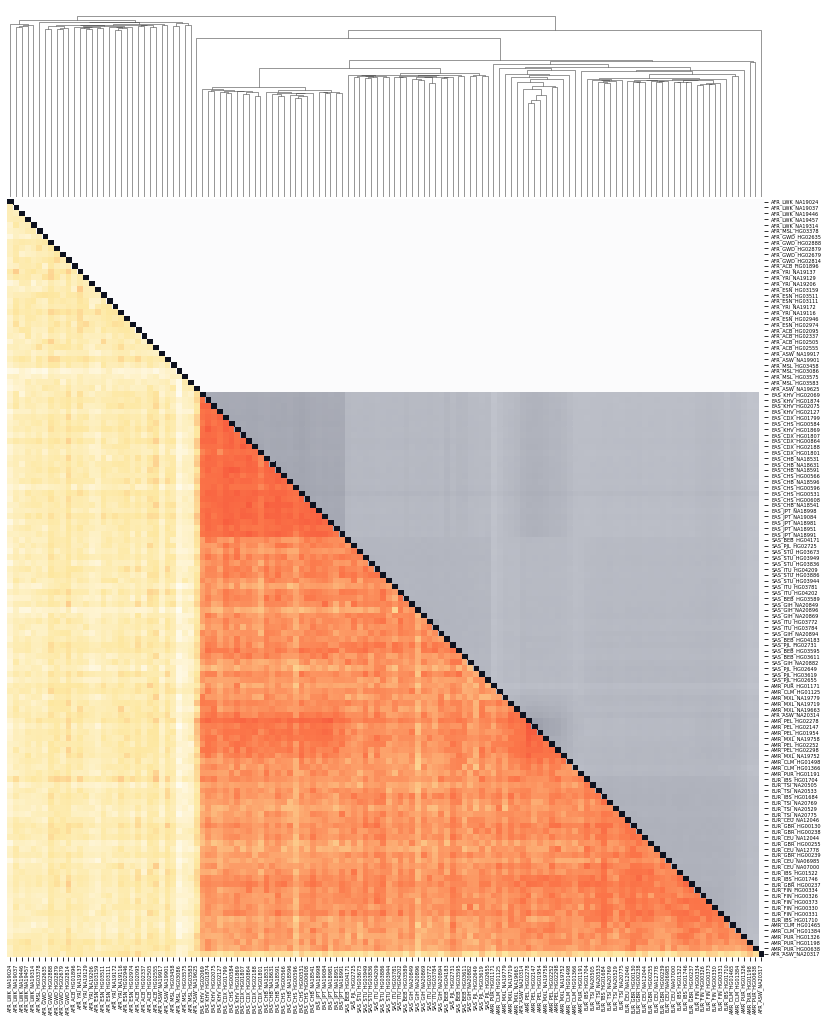

In [7]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.patches import Rectangle

# colormaps
cmap_seq = get_continuous_cmap(['#0e121ff','#9699a5','#c9ccd4','#fcfcfd'],float_list=[0, 0.5,0.99, 1])
cmap_3d = get_continuous_cmap(["#c5000e",'f44132','#fc774a',"fee8a1","#fffdf2"])
#cmap_seq = get_continuous_cmap(['#0e121ff','#9699a5','#c9ccd4','#fcfcfd'])


# Linkage and cluster baseds on sequence
linkage = hc.linkage(sp.distance.squareform(matrix_seq), method='complete',optimal_ordering=True) # complete, single, average, weighted
g = sns.clustermap(matrix_seq*2**20, row_linkage=linkage,square=True, figsize=(15,15),col_linkage=linkage, cmap = cmap_seq, vmin=150, vmax=1100, yticklabels=True, xticklabels=True)

# Flip
g.ax_heatmap.invert_xaxis()
g.ax_heatmap.invert_yaxis()
g.ax_row_dendrogram.invert_yaxis()
g.ax_col_dendrogram.invert_xaxis()
_ = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 5)
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 5)

# Color bottom triangle based on 3d genome

order = g.dendrogram_col.reordered_ind
order = [all_indivs[x] for x in order]
order = ["_".join(np.array(x.split("_"))[[0,1,3]]) if "_" in x else x for x in order]

ax = g.ax_heatmap

for i,indiv1 in enumerate(order):
    for j,indiv2 in enumerate(order):
        if i > j:
            _ = ax.add_patch(Rectangle((i-.03, j), 1.2, 1, fc=cmap_3d((matrix_3d.loc[indiv1,indiv2]-0.00043)/(0.00476-0.00043)),linewidth=0,ec=None))

g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
#plt.savefig("heatmap3dandSeq.pdf");
#plt.savefig("/home/mcarthe/heatmap3dandSeq.pdf");

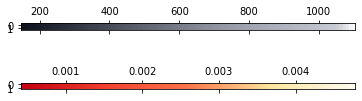

In [8]:
cmap_seq = get_continuous_cmap(['#0e121ff','#9699a5','#c9ccd4','#fcfcfd'],float_list=[0, 0.6,0.95, 1])

fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(6,2));

ax[0].matshow(np.array([np.linspace(150,1100,100),np.linspace(150,1100,100)]), cmap=cmap_seq, vmin=150, vmax=1100);
# vrange: 150 - 1100
#(m - rmin)/(rmax - rmin) * (tmax - tmin) + tmin
ax[0].set_xticks([((x - 150)/(1100 - 150) * 99) for x in np.arange(200,1100,200)]);
ax[0].set_xticklabels(np.arange(200,1100,200));

ax[1].matshow(np.array([np.linspace(0,1,100),np.linspace(0,1,100)]), cmap= cmap_3d);
# vrange = 0.00043 - 0.00476
ax[1].set_xticks([((x - 0.00043)/(0.00476 - 0.00043) * 99) for x in np.arange(0.001,0.00476,0.001)]);
ax[1].set_xticklabels(np.arange(0.001,0.00476,0.001));

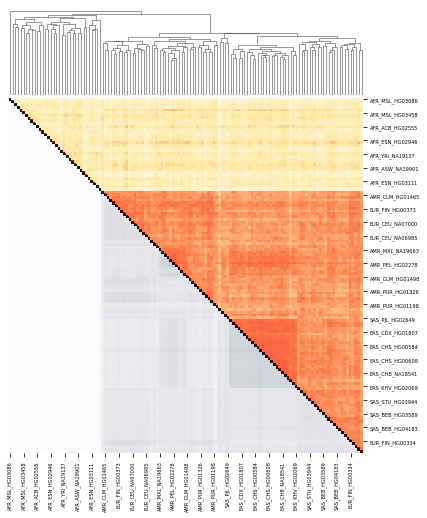

In [10]:
# Visualize together

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.patches import Rectangle

# colormaps
cmap_seq = get_continuous_cmap(['#0e121ff','#9699a5','#c9ccd4','#fcfcfd'],float_list=[0, 0.40,0.58, 1])
cmap_3d = get_continuous_cmap(["#c5000e",'f44132','#fc774a',"fee8a1","#fffdf2"])

# Linkage and cluster baseds on sequence
linkage = hc.linkage(sp.distance.squareform(matrix_3d), method='complete',optimal_ordering=True) # complete, single, average, weighted
g = sns.clustermap(matrix_3d, row_linkage=linkage, col_linkage=linkage, cmap = cmap_3d,figsize=(8,8), vmin=0.00043, vmax=0.00476)

#g.ax_col_dendrogram.invert_xaxis()
_ = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 5)
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 5)

# Color bottom triangle based on 3d genome

order = g.dendrogram_col.reordered_ind
order = [all_indivs[x] for x in order]
order = ["_".join(np.array(x.split("_"))[[0,1,3]]) if "_" in x else x for x in order]

ax = g.ax_heatmap

for i,indiv1 in enumerate(order):
    for j,indiv2 in enumerate(order):
        if i >= j:
            _ = ax.add_patch(Rectangle((j,i-0.03), 1, 1.2, fc=cmap_seq(((2**20*matrix_seq.loc[indiv1,indiv2])-150)/(1100-150)),linewidth=0,ec=None))
        #elif i == j:
            
            
g.cax.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
#plt.savefig("/home/mcarthe/heatmap3dandSeq_clusterby3d.pdf");


In [119]:
!pwd

/wynton/group/capra/projects/modern_human_3Dgenome/bin/activeNotebooks


In [147]:
np.nanmean(matrix_seq)

0.0010272449125470645

In [28]:
matrix_seq

,AMR_PUR_HG01171,EAS_CDX_HG01801,EUR_GBR_HG00255,AMR_MXL_NA19719,AMR_MXL_NA19663,EUR_CEU_NA07000,SAS_GIH_NA20869,EUR_GBR_HG00130,AFR_LWK_NA19314,SAS_PJL_HG02649,...,AFR_ESN_HG03159,AMR_CLM_HG01465,EAS_KHV_HG02069,AFR_MSL_HG03086,EAS_CHB_NA18541,SAS_ITU_HG03772,EUR_CEU_NA12778,AFR_GWD_HG02888,SAS_STU_HG03673,SAS_BEB_HG03595
AMR_PUR_HG01171,0.000000,0.000962,0.000906,0.000926,0.000929,0.000906,0.000935,0.000910,0.001214,0.000935,...,0.001234,0.000909,0.000966,0.001245,0.000954,0.000948,0.000901,0.001227,0.000955,0.000945
EAS_CDX_HG01801,0.000962,0.000000,0.000918,0.000894,0.000876,0.000919,0.000879,0.000917,0.001228,0.000899,...,0.001250,0.000907,0.000758,0.001258,0.000759,0.000876,0.000921,0.001241,0.000883,0.000861
EUR_GBR_HG00255,0.000906,0.000918,0.000000,0.000879,0.000893,0.000815,0.000876,0.000810,0.001230,0.000861,...,0.001258,0.000842,0.000926,0.001261,0.000913,0.000886,0.000813,0.001238,0.000892,0.000888
AMR_MXL_NA19719,0.000926,0.000894,0.000879,0.000000,0.000843,0.000870,0.000898,0.000870,0.001228,0.000891,...,0.001248,0.000862,0.000895,0.001255,0.000883,0.000900,0.000873,0.001234,0.000911,0.000895
AMR_MXL_NA19663,0.000929,0.000876,0.000893,0.000843,0.000000,0.000887,0.000895,0.000886,0.001224,0.000898,...,0.001245,0.000874,0.000883,0.001255,0.000868,0.000902,0.000890,0.001237,0.000908,0.000895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAS_ITU_HG03772,0.000948,0.000876,0.000886,0.000900,0.000902,0.000891,0.000838,0.000884,0.001223,0.000854,...,0.001248,0.000898,0.000878,0.001258,0.000881,0.000000,0.000890,0.001243,0.000853,0.000851
EUR_CEU_NA12778,0.000901,0.000921,0.000813,0.000873,0.000890,0.000811,0.000875,0.000812,0.001232,0.000857,...,0.001260,0.000841,0.000923,0.001261,0.000913,0.000890,0.000000,0.001238,0.000888,0.000887
AFR_GWD_HG02888,0.001227,0.001241,0.001238,0.001234,0.001237,0.001246,0.001233,0.001234,0.001228,0.001236,...,0.001205,0.001233,0.001249,0.001214,0.001242,0.001243,0.001238,0.000000,0.001239,0.001243
SAS_STU_HG03673,0.000955,0.000883,0.000892,0.000911,0.000908,0.000890,0.000845,0.000889,0.001230,0.000862,...,0.001253,0.000898,0.000886,0.001259,0.000884,0.000853,0.000888,0.001239,0.000000,0.000855
